<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

**Загрузка библиотек**:

In [1]:
import lightgbm
import numpy as np 
import pandas as pd   
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor, plot_importance
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV  

**Загрузка данных:**

In [2]:
# Загружаем данные, переводя параметр datetime в дату и индексируя таблицу по нему
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

# Посмотрим на первые 5 строк и основнуб инфу
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Посмотрим на наш временной интервал
display(df.index.min())
display(df.index.max())

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

- Интервал в 10 минут. 
- Данные за период с первого марта по 31 августа 2018 года.

Теперь проверим, в хронологичном ли порядке расположены значения в datetime.

In [5]:
df.index.is_monotonic

True

Данные упорядочены в хронологичном порядке.

In [6]:
# Проверим пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
# Ресемплирование по одному часу
df = df.resample('1H').sum()

## Анализ

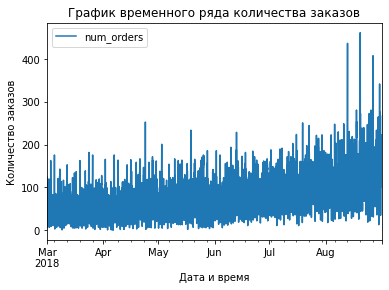

In [8]:
# Посмотрим на график данных
df.plot()
plt.title('График временного ряда количества заказов')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

Данные выглядят довольно стационарными. Добавим скользящее среднее и стандартное отклонение и посмотрим.

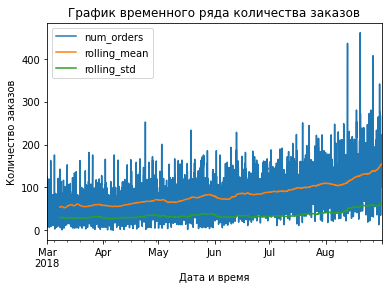

In [9]:
df['rolling_mean'] = df.rolling(24*7).mean()
df['rolling_std'] = df['num_orders'].rolling(24*7).std()

# Посмотрим снова на график
df.plot()
plt.title('График временного ряда количества заказов')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

Мы видим изменение средней и дисперсии к концу графика, данные не стационарны, но это не критично для наших моделей.

Удалим созданные признаки и добавим новые через функцию, чтобы разделить данные на трендовую, сезонную и шумовую состовляющие и построим соответствующие графики.

In [10]:
# Удаление признаков
df = df.drop(['rolling_mean', 'rolling_std'], axis=1)

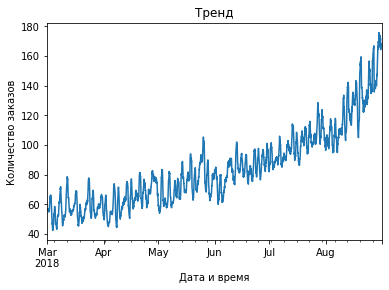

In [11]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot()
plt.title('Тренд')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

Колебания происходят на уровне недели.

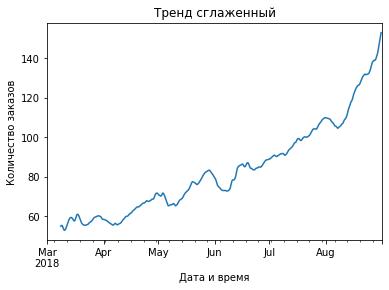

In [12]:
decomposed.trend.rolling(24*7).mean().plot()
plt.title('Тренд сглаженный')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

- Наблюдается тренд на стремительный рост: с марта по август произошел рост в 3 раза. 
- Присутствуют незначительные падения вначале месяце и рост в конце месяца.

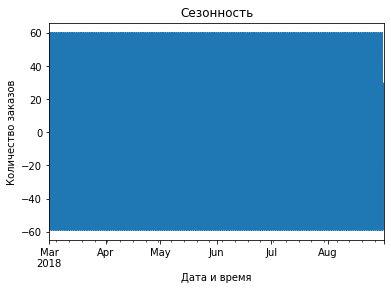

In [13]:
decomposed.seasonal.plot() 
plt.title('Сезонность')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

Сложно увидеть какую-то закономерность за такой временной промежуток в 5 месяцев.

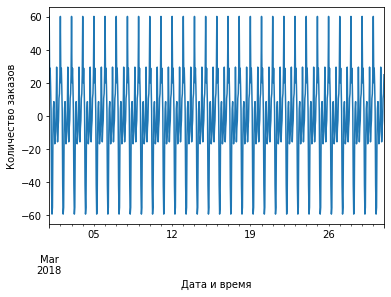

In [14]:
# график сезонной составляющей за март месяц 2018 года
decomposed.seasonal['2018-03-01':'2018-03-30'].plot()
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

Попробуем проверить сезонность на неделе

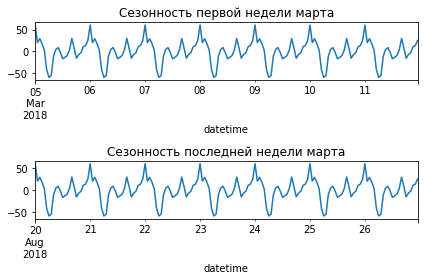

In [15]:
plt.subplot(211)
# Сезонность первой недели марта
decomposed.seasonal['2018-03-05':'2018-03-11'].plot()
plt.title('Сезонность первой недели марта')
plt.subplot(212)
# Сезонность последней недели августа
decomposed.seasonal['2018-08-20':'2018-08-26'].plot()
plt.title('Сезонность последней недели марта')
plt.tight_layout()

Данные имеют одинаковую цикличность. Проверим суточную сезонность

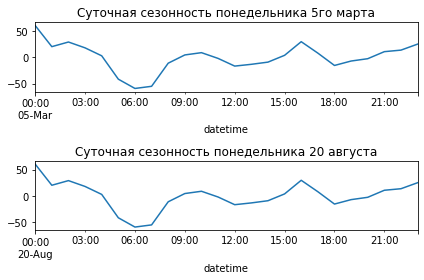

In [16]:
plt.subplot(211)
decomposed.seasonal['2018-03-05'].plot()
plt.title('Суточная сезонность понедельника 5го марта')
plt.subplot(212)
decomposed.seasonal['2018-08-20'].plot()
plt.title('Суточная сезонность понедельника 20 августа')
plt.tight_layout()

- Рост активности такси наблюдается утром (7:00-10:00), днём (12:00-16:00) и вечером (18:00-00:00), что связано с началом и окончанием рабочего дня, обедами и встречами. 
- Спад происходит после утреннего часа пик (10:00-12:00), после обеда (16:00-18:00) и ночью (00:00-6:00), когда активность минимальна. 
- Пик в полночь может быть вызван окончанием работы развлекательных заведений и снижением доступности общественного транспорта.

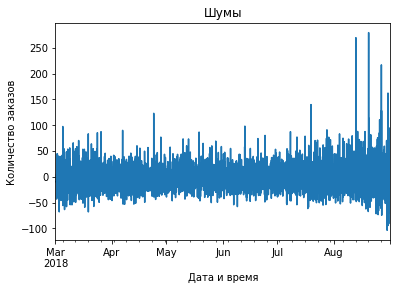

In [17]:
decomposed.resid.plot() 
plt.title('Шумы')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

- Большая амплитуда: Шум (остатки) имеет значительные колебания, особенно в конце ряда (август).
- Непостоянная дисперсия (гетероскедастичность): Размах колебаний шума меняется со временем. В начале ряда он меньше, в конце – значительно больше. Это нарушение предположения о постоянстве дисперсии остатков, которое важно для многих моделей временных рядов.
- Выбросы: Видны отдельные сильные всплески (выбросы), особенно в августе.

Скорее всего, это не ошибки, а важные события.

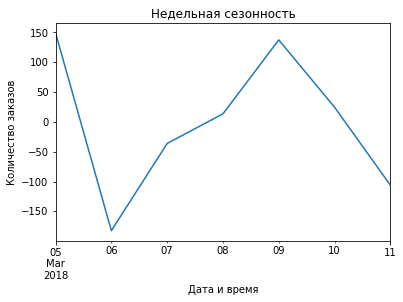

In [18]:
# Создаём копию DataFrame и агрегируем по дням
week_seasonal = df.copy().resample('1D').sum()

# Выполняем декомпозицию и строим график сезонности
seasonal_decomposed = seasonal_decompose(week_seasonal)
seasonal_decomposed.seasonal['2018-03-05':'2018-03-11'].plot()
plt.title('Недельная сезонность')
plt.xlabel('Дата и время')  
plt.ylabel('Количество заказов');

- Пики наблюдаются в понедельник и в пятницу. Неудивительно, вначале и в конце неделю люди спешат на работу и с работы. 
- А вот самый низкий спрос во вторник, но спрос потом постепенно растёт до пятницы.
- С пятницы мы наблюдаем спад до выходных.

**Вывод:**

- Наблюдается тренд равномерного роста заказов с марта по август с периодическими небольшими падениями.
- Присутствует сезонность по дням - спад после полуночи, рост с утра, днем, и вечером, пик к полуночи, а также по неделям - пики в понедельник и пятницу с резким спадом во вторник и с пятницы до конца недели, и с ростом со вторника до пятницы.

## Обучение

**Подготовка признаков:**

Создадим признаки для горизонта прогнозирования в один шаг. 

In [19]:
def make_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    # позволит модели учитывать данные за предыдущие 24 часа для прогнозирования спроса на следующий час.
    for lag in range(1, 169):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)


    # Скользящее среднее для суточной и недельной сезонности
    df['rolling_mean_24'] = df['num_orders'].shift().rolling(24).mean()
    df['rolling_mean_168'] = df['num_orders'].shift().rolling(168).mean() 
    df.dropna(inplace=True)
    
    return df

In [20]:
display(df.shape)
df = make_features(df)
display(df.shape)

(4416, 1)

(4248, 174)

In [21]:
X = df.drop('num_orders', axis=1)
y = df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [22]:
# Признаки, которые будут масштабироваться и кодироваться
numeric_features = ["rolling_mean_24", "rolling_mean_168"]
categorical_features = ["hour", "dayofweek"]

# Определим преобразования для категориальных и числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ]
)

# Создаем pipeline для линейной регрессии
linear_regression_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Модели
models = {
    "Linear Regression": linear_regression_pipeline,
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)  # Отключим лишний вывод CatBoost
}

# Гиперпараметры для GridSearch
param_grids = {
    "Linear Regression": {},  
    "Decision Tree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [10, 100, 150],
        "max_depth": [5, 10]
    },
    "LightGBM": {
        "n_estimators": [50, 100],
        "learning_rate": [0.05, 0.1],
        "max_depth": [5, 10]
    },
    "CatBoost": {
        "learning_rate": [0.1, 0.2, 1],
        "depth": [5, 10]
    }
}

In [23]:
# Создаем TimeSeriesSplit с 3 фолдами
tscv = TimeSeriesSplit(n_splits=3)

# Перебор моделей и их гиперпараметров
# Сохранение результатов всех моделей
best_models = {}
results = []
for name, model in models.items():
    print(f"Обучение {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring="neg_root_mean_squared_error", cv=tscv)
    grid_search.fit(X_train, y_train)
    
    # Сохраним лучшую модель
    best_models[name] = grid_search.best_estimator_
        
    # Преобразуем лучший результат (MSE) в RMSE
    best_rmse = np.sqrt(abs(grid_search.best_score_))

    # Добавляем результаты в список
    results.append({
        "Модель": name,
        "Лучшие параметры": grid_search.best_params_,
        "Лучший результат (RMSE)": best_rmse
    })

# Выводим результаты
results_df = pd.DataFrame(results)
display(results_df)

Обучение Linear Regression...
Обучение Decision Tree...
Обучение Random Forest...
Обучение LightGBM...
Обучение CatBoost...


,Модель,Лучшие параметры,Лучший результат (RMSE)
0,Linear Regression,{},5.181913
1,Decision Tree,"{'max_depth': 5, 'min_samples_split': 10}",5.367682
2,Random Forest,"{'max_depth': 10, 'n_estimators': 150}",4.890366
3,LightGBM,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",4.859205
4,CatBoost,"{'depth': 5, 'learning_rate': 0.1}",4.927634


LightGBM показала наилучший результат (RMSE: 4.85), за ней следуют Random Forest (4.89) и CatBoost (4.92). Все модели удовлетворяют условию RMSE ≤ 48, поэтому для прогнозирования лучше использовать LightGBM.

## Тестирование

In [ ]:
# Финальное обучение CatBoost на всей обучающей выборке
lightgbm = best_models['LightGBM']
lightgbm.fit(X_train, y_train)

# Прогноз на тестовых данных
y_pred = lightgbm.predict(X_test)

# Расчёт RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Финальный RMSE на тестовой выборке: {final_rmse:.2f}")

Финальный RMSE на тестовой выборке: 36.80


Финальный RMSE на тестовой выборке 36.8, что удовлетворяет условию задачи, хотя разрыв между тренировчной довольно большой.

In [25]:
# Лаг 24 - предсказание значением этого же часа предыдущих суток
baseline_lag_24 = X_test['lag_24']

# Лаг 168 - предсказание значением этого же часа и дня недели с предыдущей недели
baseline_lag_168 = X_test['lag_168']

# Расчёт RMSE для бейзлайнов
rmse_lag_24 = np.sqrt(mean_squared_error(y_test, baseline_lag_24))
rmse_lag_168 = np.sqrt(mean_squared_error(y_test, baseline_lag_168))

print(f"RMSE для бейзлайна с лагом 24: {rmse_lag_24:.2f}")
print(f"RMSE для бейзлайна с лагом 168: {rmse_lag_168:.2f}")

RMSE для бейзлайна с лагом 24: 55.86
RMSE для бейзлайна с лагом 168: 39.29


Сравнение моделей показало, что наилучший результат на тренировочных данных продемонстрировала модель LightGBM с RMSE 4.85, что превосходит Random Forest (4.89) и CatBoost (4.92). Все модели соответствуют условию RMSE ≤ 48, поэтому для прогнозирования была выбрана LightGBM.

На тестовой выборке LightGBM также продемонстрировала финальное RMSE 36.80, что значительно лучше бейзлайновых моделей:

Лаг 24 (предсказание значением этого же часа предыдущих суток) показал RMSE 55.86.
Лаг 168 (предсказание значением этого же часа на предыдущей неделе) дал RMSE 39.29.
Таким образом, LightGBM превосходит базовые методы прогнозирования и является наиболее подходящей моделью для использования.

## Общий вывод

В ходе проекта были собраны и обработаны данные компании «Чётенькое такси» по заказам такси в аэропортах за период с марта по август 2018 года с интервалом в 10 минут. Данные были ресемплированы по одному часу и проверены на наличие пропусков (не обнаружено). Анализ временных рядов показал:

- Тренд: Устойчивый рост заказов с марта по август.
- Сезонность: Была определена суточная сезонность. Спад заказов после полуночи, рост утром и вечером, пик к полуночи. Также определена недельная сезонность, где пик в пн и в пт, рост с вт до пт, спад с пн по вт, с пт по вс.
- Выбросы: Заметные всплески заказов, особенно в августе, вероятно, из-за особых событий.
- Стационарность: Визуальная оценка подтвердила не тсационарность.

Для прогнозирования обучены несколько моделей с различными гиперпараметрами, включая LinearRegression, DecisionTreeRegressor, CatBoost, LightGBM, Random Forest:

- LightGBM показала наилучший результат на тренировочной выборке (RMSE: 4.85).
- Random Forest и CatBoost также показали хорошие результаты (RMSE: 4.89 и 4.92 соответственно).

Финальное тестирование модели CatBoost дало RMSE на тестовой выборке 36.8, что удовлетворяет условию задачи (≤ 48). Хотя разрыв между тренировочным и тестовым RMSE присутствует, модель может использоваться для прогнозирования количества заказов такси на следующий час, обеспечивая приемлемую точность в реальных условиях.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48